<a href="https://colab.research.google.com/github/GitMarco27/TMML/blob/main/Notebooks/011_Dtw_Loss_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 Minutes Machine Learning
## FROM Episode 11: Dtw Loss Function

Slightly modified from
#### Marco Sanguineti, 2021
---


Tested on PC win1064-1036593 tf262 (note this is the lower case version!!)
18th August 2023

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.6.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Creating data

---
This works nicely


(500, 50)

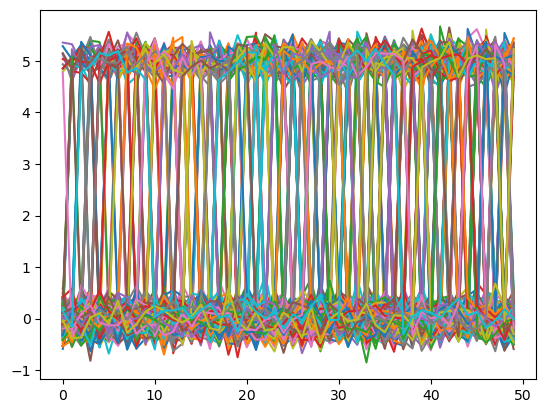

In [3]:
import random
n=50
records=500
noise_amplitude = 0.2  # Adjust the amplitude of the noise

xs=[]
ys=[]
for i in range(records):
    #Draw a straight line
    line = [0 for val in range(n)]
    opens = [5 for val in range(n)]
    # hHw many events?
    events = random.randint(0,5)
    lengths = np.random.randint(1,high=10,size=events)
    miin=0
    
    for event in range(events):
        if miin+lengths[event] < n:
            start = random.randint(miin,n-lengths[event])
            fin = start + lengths[event]
            miin = fin
            line[start:fin] = opens[start:fin]

    # Add noise to the sine wave            
    random_noise = np.random.normal(0, noise_amplitude, n)   

    xs.append(line + random_noise)
    ys.append(line)
    plt.plot(xs[i])
    
np.asarray(xs).shape


Create a couple of curves as actual tensors

In [4]:
#x = tf.Variable(np.cos(np.linspace(0, n)*3.14/180).reshape(1, -1))
#have made a load of them now
# WHY ARE WE making all these tf.variables if we just numpy them before run!!?
#x = tf.Variable(np.asarray(xs).reshape(batch_size,-1))
#y = tf.Variable(np.asarray(ys).reshape(batch_size,-1))
# Convert data to TensorFlow Tensors
x = tf.convert_to_tensor(np.asarray(xs).reshape(records,-1), dtype=tf.float32)
y = tf.convert_to_tensor(np.asarray(ys).reshape(records,-1), dtype=tf.float32)


For a look-see, convery back to numpy and plot'em

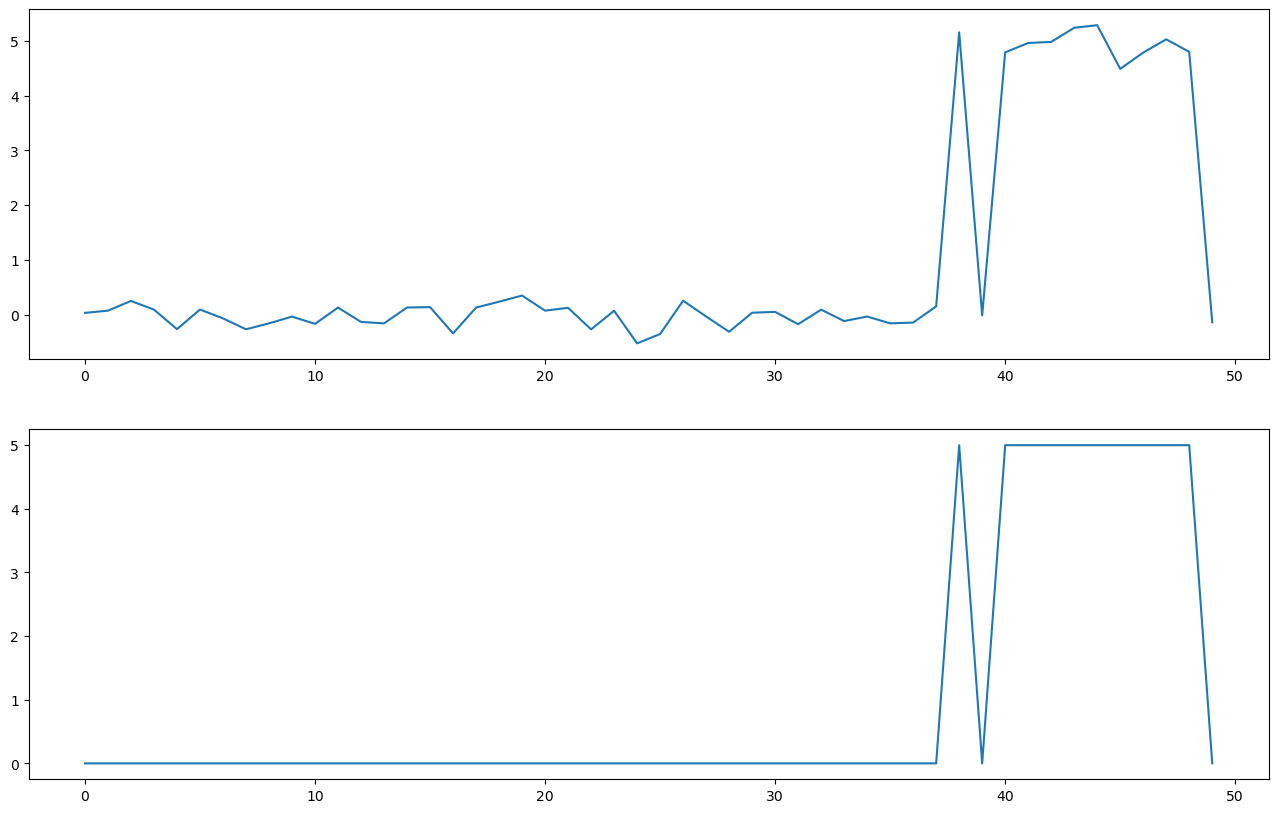

In [5]:
fig, axs = plt.subplots(nrows=2, figsize=(16, 10))
#just plot the first x!
axs[0].plot(x.numpy()[0].reshape(-1))
axs[1].plot(y.numpy()[0].reshape(-1))
plt.show()

Create the loss class
and just see if it works by calling with x as the data and y as the prediction

So it works and returns a suitable value; of course converted to a regular variable to print.

## Basic Stacked Autoencoder Implementation


---
A simple (encoder) NN model with just one layer and 10 fully connected neurones

In [6]:
# Encoder
input = tf.keras.layers.Input(shape=(x.shape[1]))
dense_1 = tf.keras.layers.Dense(10, activation='relu')(input)
encoder = tf.keras.models.Model(inputs=input, outputs=dense_1)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
Total params: 510
Trainable params: 510
Non-trainable params: 0
_________________________________________________________________


In [7]:
x.shape

TensorShape([500, 50])

...and a matching decoder....

In [8]:
# Decoder
input = tf.keras.layers.Input(shape=(10))
dense_1 = tf.keras.layers.Dense(x.shape[1], activation='linear')(input)
decoder = tf.keras.models.Model(inputs=input, outputs=dense_1)
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                550       
Total params: 550
Trainable params: 550
Non-trainable params: 0
_________________________________________________________________


In [9]:
# AE

model2 = tf.keras.models.Sequential([
                                    encoder,
                                    decoder
])
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 10)                510       
_________________________________________________________________
model_1 (Functional)         (None, 50)                550       
Total params: 1,060
Trainable params: 1,060
Non-trainable params: 0
_________________________________________________________________


In [12]:
#Alternative version based on my attempt.
class DtwLossKG(tf.keras.losses.Loss):
    def __init__(self, norm="L1", window_size=0.1, force_symmetry=False):  #can add other generic setups here like batch id desired
        super(DtwLossKG, self).__init__()
        self.norm = norm # either "L1" or "L2"
        self.window_size = window_size # either a fixed integer or a relative float
        self.force_symmetry = force_symmetry # either True or False
        
    def call(self, y_true, y_predict):
        LB_sum = tf.constant(0.0, dtype=tf.float32)  # Initialize the loss sum
        batch_size=y_predict.shape[0]
        for batch in range(batch_size):
            s1=y_true[batch,:]
            s2=y_predict[batch,:]
            # compute window size based on input
            if isinstance(self.window_size, int):
                r = tf.constant(self.window_size, dtype=tf.int32)
            elif isinstance(self.window_size, float):
                r = tf.cast(tf.math.round(self.window_size * len(s1)), dtype=tf.int32)
            else:
                raise ValueError("Invalid window size")
            # compute lower bound based on norm
            if self.norm == "L1":
                LB_sum += self.LB_Keogh_L1(s1, s2, r)
                if self.force_symmetry:
                    LB_sum += self.LB_Keogh_L1(s2, s1, r)
            elif self.norm == "L2":
                LB_sum += self.LB_Keogh_L2(s1, s2, r)
                if self.force.symmetry:
                    LB_sum += self.LB_Keogh_L2(s2, s1, r)
            else:
                raise ValueError("Invalid norm")
        return LB_sum/tf.cast(batch_size,dtype=tf.float32)

    def LB_Keogh_L1(self, x, y, r):
        # compute L1 norm lower bound
        LB_sum = tf.constant(0.0, dtype=tf.float32)
        for index in range(len(x)):
            ind=tf.cast(index,dtype=tf.int32)
            i=tf.cast(x[ind],dtype=tf.float32)
            lower_bound = tf.reduce_min(y[(ind - r if ind - r >= 0 else 0):\
                                           (ind + r if ind + r < len(x) else len(x))])
            upper_bound = tf.reduce_max(y[(ind - r if ind - r >= 0 else 0):\
                                           (ind + r if ind + r < len(x) else len(x))])
            if i > upper_bound:
                LB_sum += tf.abs(i - upper_bound)
            elif i < lower_bound:
                LB_sum += tf.abs(i - lower_bound)
        return LB_sum

    def LB_Keogh_L2(self, x, y, r):
        # compute L2 norm lower bound
        LB_sum = tf.constant(0.0, dtype=tf.float32)
        for index in range(len(x)):
            ind=tf.cast(index,dtype=tf.int32)
            i=tf.cast(x[ind],dtype=tf.float32)
            lower_bound = tf.reduce_min(y[(ind - r if ind - r >= 0 else 0):\
                                           (ind + r if ind + r < len(x) else len(x))])
            upper_bound = tf.reduce_max(y[(ind - r if ind - r >= 0 else 0):\
                                           (ind + r if ind + r < len(x) else len(x))])
            if i > upper_bound:
                LB_sum += tf.math.square(i - upper_bound)
            elif i < lower_bound:
                LB_sum += tf.math.square(i - lower_bound)
        return LB_sum

    
lossKG = DtwLossKG(norm="L2", window_size=0.1, force_symmetry=True)
model2 = tf.keras.models.Sequential([
                                    encoder,
                                    decoder
])
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss=lossKG)




In [13]:
history2=model2.fit(x, y, epochs=100, batch_size=1)

Epoch 1/1000
5/5 [==============================] - 4307s 6s/step - loss: 28.2744
Epoch 2/1000
5/5 [==============================] - 28s 6s/step - loss: 26.3013
Epoch 3/1000
5/5 [==============================] - 27s 6s/step - loss: 24.1478
Epoch 4/1000
5/5 [==============================] - 28s 6s/step - loss: 21.7084
Epoch 5/1000
5/5 [==============================] - 28s 6s/step - loss: 19.2220
Epoch 6/1000
5/5 [==============================] - 28s 6s/step - loss: 16.6293
Epoch 7/1000
5/5 [==============================] - 28s 6s/step - loss: 14.1328
Epoch 8/1000
5/5 [==============================] - 28s 6s/step - loss: 11.8491
Epoch 9/1000
5/5 [==============================] - 28s 6s/step - loss: 9.7639
Epoch 10/1000
5/5 [==============================] - 28s 6s/step - loss: 8.0313
Epoch 11/1000
5/5 [==============================] - 28s 6s/step - loss: 6.6146
Epoch 12/1000
5/5 [==============================] - 28s 6s/step - loss: 5.4995
Epoch 13/1000
5/5 [====================

5/5 [==============================] - 28s 6s/step - loss: 0.1295
Epoch 104/1000
5/5 [==============================] - 29s 6s/step - loss: 0.1275
Epoch 105/1000
5/5 [==============================] - 28s 6s/step - loss: 0.1258
Epoch 106/1000
5/5 [==============================] - 28s 6s/step - loss: 0.1242
Epoch 107/1000
5/5 [==============================] - 28s 6s/step - loss: 0.1229
Epoch 108/1000
5/5 [==============================] - 28s 6s/step - loss: 0.1217
Epoch 109/1000
5/5 [==============================] - 29s 6s/step - loss: 0.1203
Epoch 110/1000
5/5 [==============================] - 29s 6s/step - loss: 0.1194
Epoch 111/1000
5/5 [==============================] - 28s 6s/step - loss: 0.1179
Epoch 112/1000
5/5 [==============================] - 28s 6s/step - loss: 0.1169
Epoch 113/1000
5/5 [==============================] - 28s 6s/step - loss: 0.1157
Epoch 114/1000
5/5 [==============================] - 28s 6s/step - loss: 0.1148
Epoch 115/1000
5/5 [=======================

5/5 [==============================] - 28s 6s/step - loss: 0.0513
Epoch 205/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0507
Epoch 206/1000
5/5 [==============================] - 29s 6s/step - loss: 0.0501
Epoch 207/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0496
Epoch 208/1000
5/5 [==============================] - 29s 6s/step - loss: 0.0491
Epoch 209/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0485
Epoch 210/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0481
Epoch 211/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0476
Epoch 212/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0471
Epoch 213/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0465
Epoch 214/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0461
Epoch 215/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0456
Epoch 216/1000
5/5 [=======================

5/5 [==============================] - 28s 6s/step - loss: 0.0202
Epoch 306/1000
5/5 [==============================] - 29s 6s/step - loss: 0.0201
Epoch 307/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0199
Epoch 308/1000
5/5 [==============================] - 29s 6s/step - loss: 0.0197
Epoch 309/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0196
Epoch 310/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0194
Epoch 311/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0193
Epoch 312/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0191
Epoch 313/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0190
Epoch 314/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0188
Epoch 315/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0186
Epoch 316/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0185
Epoch 317/1000
5/5 [=======================

5/5 [==============================] - 28s 6s/step - loss: 0.0069
Epoch 407/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0068
Epoch 408/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0067
Epoch 409/1000
5/5 [==============================] - 29s 6s/step - loss: 0.0067
Epoch 410/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0066
Epoch 411/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0065
Epoch 412/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0065
Epoch 413/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0064
Epoch 414/1000
5/5 [==============================] - 29s 6s/step - loss: 0.0063
Epoch 415/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0062
Epoch 416/1000
5/5 [==============================] - 29s 6s/step - loss: 0.0062
Epoch 417/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0061
Epoch 418/1000
5/5 [=======================

5/5 [==============================] - 28s 6s/step - loss: 0.0023
Epoch 508/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0022
Epoch 509/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0022
Epoch 510/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0022
Epoch 511/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0021
Epoch 512/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0021
Epoch 513/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0020
Epoch 514/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0020
Epoch 515/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0019
Epoch 516/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0019
Epoch 517/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0019
Epoch 518/1000
5/5 [==============================] - 29s 6s/step - loss: 0.0019
Epoch 519/1000
5/5 [=======================

5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 607/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 608/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 609/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 610/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 611/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 612/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 613/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 614/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 615/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 616/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 617/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000

5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 703/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 704/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 705/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 706/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 707/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 708/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 709/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 710/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 711/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 712/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 713/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000

5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 799/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 800/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 801/1000
5/5 [==============================] - 29s 6s/step - loss: 0.0000e+00
Epoch 802/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 803/1000
5/5 [==============================] - 29s 6s/step - loss: 0.0000e+00
Epoch 804/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 805/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 806/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 807/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 808/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 809/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000

5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 895/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 896/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 897/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 898/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 899/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 900/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 901/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 902/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 903/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 904/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 905/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000

5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 991/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 992/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 993/1000
5/5 [==============================] - 29s 6s/step - loss: 0.0000e+00
Epoch 994/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 995/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 996/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 997/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 998/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 999/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00
Epoch 1000/1000
5/5 [==============================] - 28s 6s/step - loss: 0.0000e+00


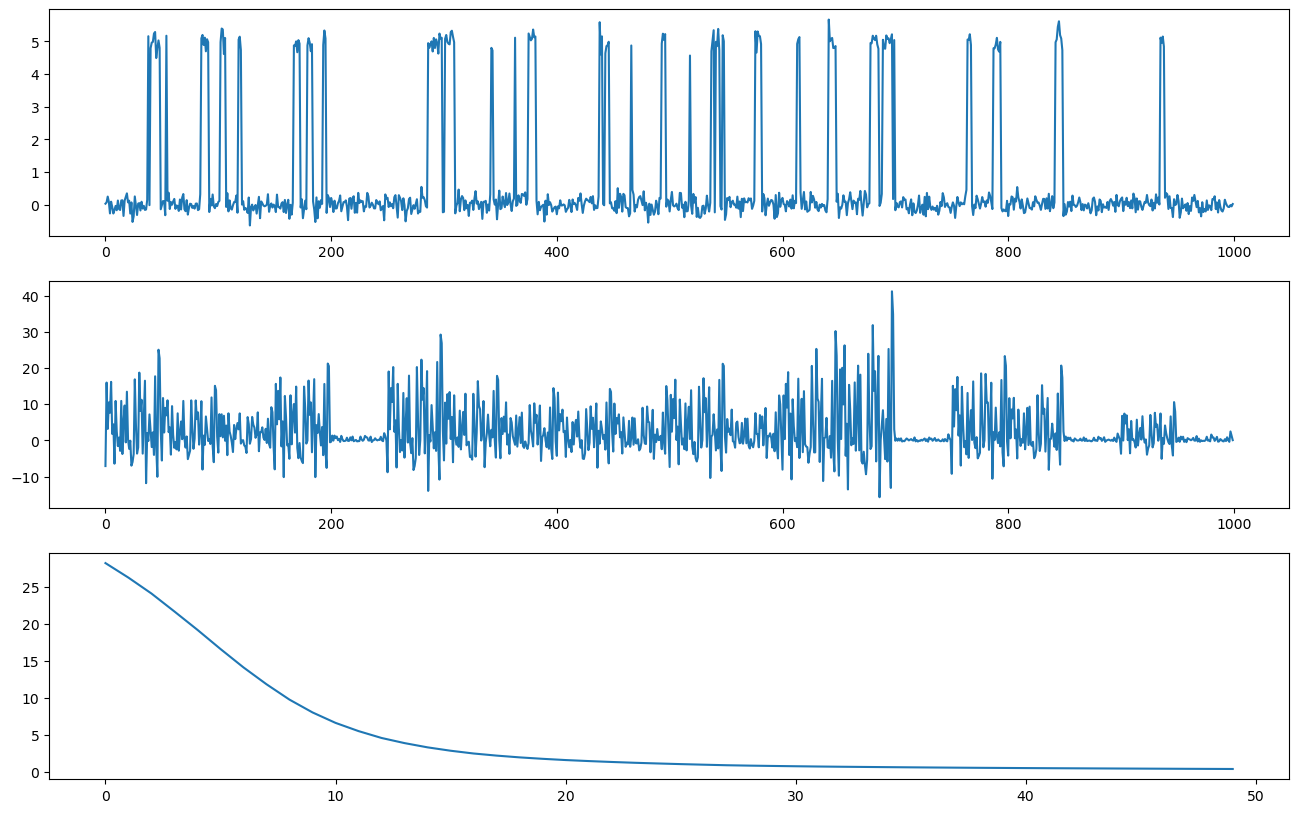

In [16]:
import math
fig, axs = plt.subplots(nrows=3, figsize=(16, 10))
axs[0].plot(x.numpy().reshape(-1)[:1000])
axs[1].plot(model2(x.numpy()).numpy().reshape(-1)[:1000])
axs[2].plot(history2.history["loss"][:50])
#axs[2].set_ylim([0,math.ceil(max(history2.history["loss"]))])
plt.show()